# 风格迁移

这次的workshop带来使用卷积神经网络将一幅图的纹理风格应用到另一幅图上的技术: 风格迁移(Neural style transfer). 这个技术的出处为论文[A Neural Algorithm of Artistic Style](https://arxiv.org/abs/1508.06576), 论文不是特别深奥, 非常值得一读.

先简单介绍一下风格迁移技术原理:

它是一种优化技巧, 用到三张图: **内容**图, **风格参考**图, **输入**图. 这种技巧将会去不停地优化**输入**图, 使得它含有更多的**内容**图中的内容, 并且使用更多的**风格参考**图中的"绘画风格"绘制.

具体怎么做? 我们需要定义两个距离函数, 一个用于描述两张图片的内容有多少不同, 即$L_{content}$; 另一个用于描述两张图片的绘制风格有多不同, 即$L_{style}$. 
给到上述三张图: **content**, **style**, **input**(初始化为content)之后, 我们要做的就是通过不断修改**input**图, 使得$L_{content}(content, input)$与$L_{style}(style, input)$越来越小. 

### import必要的组件和初始化

In [1]:
from datetime import datetime
from tensorflow.contrib import eager
from tensorflow.python.keras import Model
from tensorflow.python.keras.applications.vgg19 import preprocess_input, VGG19
from tensorflow.python.keras.preprocessing.image import load_img, img_to_array
%matplotlib inline

import numpy as np
import tensorflow as tf

开启tensorflow中的eager execution, 这将使我们的代码写来更像常规代码逻辑, 而不是tf中传统的先定义计算图, 再通过会话机制执行运算.

In [2]:
tf.enable_eager_execution()

定义几个辅助函数, 方便之后读取和显示图片. 这里值得注意的是深度学习中的图片预处理方法很多, 这次我们将会使用预训练的VGG模型, 而该模型在训练时将训练数据归一化到`mean = [103.939, 116.779, 123.68]`. 

那么我们的图片在经过同样的预处理后也会有相同的情况, 所以在显示图片时需要将其还原到0-255的范围, 即`x += [103.939, 116.779, 123.68]`.

In [3]:
def display_image(*images, col=None, width=20):
    """接收若干个图像参数images, 将其尽数绘制
    col: 一行显示多少张图片
    width: 总画布宽度
    """
    from matplotlib import pyplot as plt

    if col is None:
        col = len(images)
    row = np.math.ceil(len(images) / col)
    plt.figure(figsize=(width, (width + 1) * row / col))
    for i, image in enumerate(images):
        plt.subplot(row, col, i + 1)
        plt.axis('off')
        plt.imshow(image, cmap='gray')
    plt.show()


def preprocess(image_path):
    """通过路径读取图片并预处理成4维张量方便深度学习模型使用
    由于图片过大会严重影响运算速度, 将其缩放到长边512px并保持原有aspect ratio
    """
    max_dim = 512
    image = load_img(image_path)
    image.thumbnail((max_dim, max_dim))
    image = img_to_array(image)
    image = np.expand_dims(image, axis=0)
    return preprocess_input(image)


def deprocess(image):
    """将预处理之后的图片还原到HxWx3的张量形状并还原色彩到0-255
    """
    x = image.copy()
    x = np.squeeze(x, 0)
    x[:, :, 0] += 103.939
    x[:, :, 1] += 116.779
    x[:, :, 2] += 123.680
    x = x[:, :, ::-1]
    x = np.clip(x, 0, 255).astype('uint8')
    return x

### 定义content的style的表示方式

我们需要以某种方式把传入的图片的content和style描述表示出来, 方法为将图片传进VGG模型中并提取中间层输出. 我们又知道模型的越深层提取到的特征越抽象, 越高层, 即越能代表图像中的内容信息; 反之越低层, 比如边角信息, 形状信息等. 
基于这一点, 我们可以运用不同层的输出来计算前面提到的两个距离函数$L_{content}$和$L_{style}$. 

#### 为什么要使用中间层

你可能不太理解为什么模型的中间层能表示这些图片中的内容. 我们大致可以这么来理解: VGG模型是用来做图像分类(image classification)的, 而为了能完成这个任务, 模型必须得"理解"图像. 深度卷积神经网络模型在理解图像的过程是从图像的原始像素信息开始, 一层一层地提取特征, 从边角到形状, 再到更为抽象的"头", "眼"等特征, 逐渐形成对图像所包含信息的复杂理解. 所以在从图像进入模型到最终模型输出分类结果之间的所有层都可以作为不同程度的特征提取工具, 包括图像信息特征和风格特征. 

这里我们尝试使用位置较深的中间层作为内容特征提取, 由浅到深的中间层组合共同作为风格特征提取:

In [4]:
content_layers = ['block5_conv2']
style_layers = [
    'block1_conv1',
    'block2_conv1',
    'block3_conv1',
    'block4_conv1',
    'block5_conv1',
]
num_content_layers = len(content_layers)
num_style_layers = len(style_layers)

### 创建模型

我们使用VGG19作为基础模型, 再根据定义好的内容和风格特征层获取中间层输出, 创建新的模型, 使得将图片传进模型后能分别得到内容和风格信息. 

In [4]:
def get_model():
    vgg = VGG19(include_top=False)
    vgg.trainable = False
    content_outputs = [vgg.get_layer(name).output for name in content_layers]
    style_outputs = [vgg.get_layer(name).output for name in style_layers]
    return Model(vgg.input, style_outputs + content_outputs)

## 定义距离函数(loss functions)

### content loss

内容距离的定义其实非常简单. 我们将content图和input图分别传入定义的模型获取到content层的特征向量$a, b$, 然后求这两个向量的欧氏距离$d=\sqrt{(a-b)^2}$, 这个距离即两张图的内容差距.

In [4]:
def get_content_loss(base_content, target):
    return tf.reduce_mean(tf.square(base_content - target))

### style loss

风格距离的定义域内容距离差不多, 只不过不是直接拿中间层的输出特征进行欧氏距离运算, 而是用输出特征的gram matrix进行欧氏距离运算. 

In [4]:
def gram_matrix(x):
    channels = int(x.shape[-1])
    a = tf.reshape(x, [-1, channels])
    n = tf.shape(a)[0]
    gram = tf.matmul(a, a, transpose_a=True)
    return gram / tf.cast(n, tf.float32)


def get_style_loss(generated_style, base_gram_style):
    gram_style = gram_matrix(generated_style)
    return tf.reduce_mean(tf.square(gram_style - base_gram_style)) * 1

## 应用风格迁移

我们定义一些辅助函数来完成风格迁移代码的实现. 

对于content图, 我们只需要它的content特征, 而style图只需要style特征, 所以我们定义`get_feature_repr`函数分别获取这两个特征, 函数接收`model, content_image, style_image`这三个参数, 即创建的神经网络模型, 两张图.

In [4]:
def get_feature_repr(model, content_image, style_image):
    style_outputs = model(style_image)
    content_outputs = model(content_image)

    style_features = [layer[0] for layer in style_outputs[:num_style_layers]]
    content_features = [layer[0] for layer in content_outputs[num_style_layers:]]
    return style_features, content_features

使用上面定义的loss函数来计算总的loss, 这个loss即为风格迁移需要优化的函数. 

$Loss=\alpha L_{conetnt} + \beta L_{style}$

其中$\alpha,\beta$分别为内容距离和风格距离的权重

拿到loss之后, 我们再通过tf的API计算出loss关于input图的梯度(gradients), 有了梯度才能对input图进行修改.

In [4]:
def compute_loss(model, generated_image, gram_style_features, content_features, content_weight, style_weight):
    model_outputs = model(generated_image)
    output_style_features = model_outputs[:num_style_layers]
    output_content_features = model_outputs[num_style_layers:]

    content_loss, style_loss = 0, 0

    w = 1. / num_style_layers
    for target_style, gen_style in zip(gram_style_features, output_style_features):
        style_loss += w * get_style_loss(gen_style[0], target_style)

    w = 1. / num_content_layers
    for target_content, gen_content in zip(content_features, output_content_features):
        content_loss += w * get_content_loss(gen_content[0], target_content)

    content_loss *= content_weight
    style_loss *= style_weight

    loss = content_loss + style_loss
    return loss, style_loss, content_loss


def compute_grads(configs):
    with tf.GradientTape() as tape:
        all_loss = compute_loss(**configs)
    loss = all_loss[0]
    return tape.gradient(loss, configs['generated_image']), all_loss

## 优化迭代

风格迁移的完整过程:

1. 分别读取content, style两张图
2. 创建模型, 并将content, style图传入该模型, 分别拿到content图的内容特征$c$和style图的风格特征$s$
3. 将风格特征用gram matrix处理, 拿到gram style特征
4. 初始化input图, 使其和content图相同
5. 让input图进入2中的模型, 得到其内容和风格特征 $c_0$和$s_0$
6. 计算$L_{content}(c, c_0)$和$L_{style}(s, s_0)$
7. 通过$L_{content}, L_{style}$计算梯度$g$
8. 用Adam优化算法将$g$应用到input图上
9. 重复迭代5 - 8若干次

In [5]:
import IPython.display as display

def run(content_path, style_path, num_iters=1000, content_weight=1e3, style_weight=1e-2, lr=10):
    content_image = preprocess(content_path)
    style_image = preprocess(style_path)

    model = get_model()
    for layer in model.layers:
        layer.trainable = False

    style_features, content_features = get_feature_repr(model, content_image, style_image)
    gram_style_features = [gram_matrix(x) for x in style_features]

    init_image = preprocess(content_path)
    generated_image = eager.Variable(init_image, dtype=tf.float32)

    opt = tf.train.AdamOptimizer(learning_rate=lr, beta1=.99, epsilon=1e-1)

    best_loss, best_image = float('inf'), None
    configs = {
        'model': model,
        'generated_image': generated_image,
        'gram_style_features': gram_style_features,
        'content_features': content_features,
        'content_weight': content_weight,
        'style_weight': style_weight,
    }

    norm_means = np.array([103.939, 116.779, 123.68])
    min_vals = -norm_means
    max_vals = 255 - norm_means

    tick = datetime.now()
    global_start = datetime.now()
    
    eval_steps = 50
    
    for i in range(num_iters):
        gradients, all_loss = compute_grads(configs)
        opt.apply_gradients([(gradients, generated_image)])
        

        if all_loss[0] < best_loss:
            best_loss = all_loss[0]
            best_image = deprocess(generated_image.numpy())
        
        if (i + 1) % eval_steps == 0:
            tock = datetime.now()
            plot_image = deprocess(generated_image.numpy())
            display.clear_output(wait=True)
            display_image(plot_image, width=7)

            print("Iteration #{}/{} | Loss: {:.4e} | Style loss: {:.4e} | Content loss: {:.4e} | Time: {:.3f}s".format(
                i + 1, num_iters,
                *all_loss,
                (tock - tick).total_seconds() / eval_steps
            ))
            tick = tock
    print("Iteration #{0}/{0} | Total Time: {1:.4f}s".format(num_iters, (datetime.now() - global_start).total_seconds()))

    return best_image, best_loss

看效果:

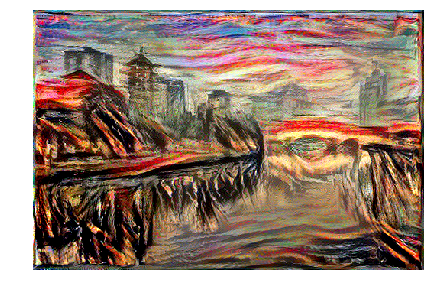

Iteration #1000/1000 | Loss: 6.2074e+06 | Style loss: 3.3758e+06 | Content loss: 2.8316e+06 | Time: 0.269s
Iteration #1000/1000 | Total Time: 269.0788s


In [8]:
content_path = 'assets/chengdu.jpg'
style_path = 'assets/shocked.jpg'
content_weight = 1e3
style_weight = 3e-2

best_image, best_loss = run(
    content_path, style_path, 
    num_iters=1000, lr=3,
    content_weight=content_weight, style_weight=style_weight
)

The best loss is: 6.20741e+06


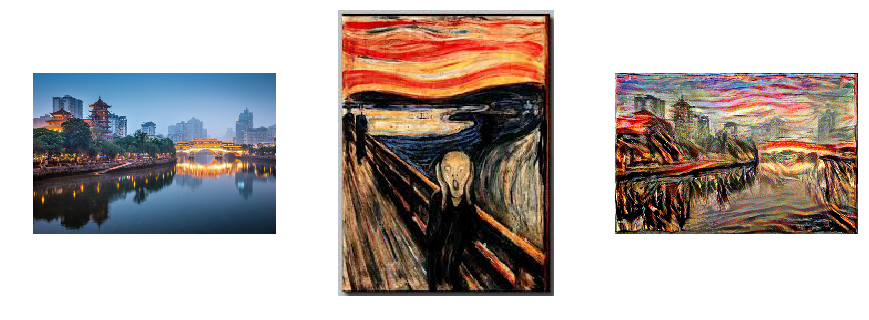

In [9]:
print("The best loss is: {:.5e}".format(best_loss))
content_image = preprocess(content_path)
style_image = preprocess(style_path)
display_image(deprocess(content_image), deprocess(style_image), best_image, col=4, width=20)